## V4

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

CATEGORY_FREQ = 100

In [2]:
df_shops = pd.read_csv("shops.csv")
df_shops.describe()

,shop_id
count,60.00000
mean,29.50000
std,17.46425
min,0.00000
25%,14.75000
50%,29.50000
75%,44.25000
max,59.00000


In [3]:
# get valid shop id
def valid_shop_id(id):
    if id == 0:
        return 57
    if id == 1:
        return 58
#    if id == 23:
#        return 24
    if id == 11:
        return 10
    if id == 40:
        return 39 
    return id

def shop_type(shop):
    #types = ['ТК', 'ТЦ', 'ТРК', 'ТРЦ']
    p = re.compile(r"(Т[РКЦ]+)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    if 'нлайн' in shop: return 'Онлайн'
    if 'нтернет' in shop: return 'Онлайн'
    return 'Магазин'

# get city
def shop_city(shop):
    p = re.compile(r"^([а-яА-Я\.]*)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    return 'Unknown'

#df_shops['valid_id'] = df_shops['shop_id'] 

In [4]:
df_shops.drop([0,1], inplace=True)

In [5]:
df_shops['city'] = df_shops['shop_name'].apply(lambda x: shop_city(x))
df_shops['type'] = df_shops['shop_name'].apply(lambda x: shop_type(x))
df_shops['mega'] = df_shops['shop_name'].str.contains('мега', case=False).astype(int)

In [6]:
df_shops = df_shops.set_index('shop_id')
df_shops.tail()

,shop_name,city,type,mega
shop_id,,,,
55,Цифровой склад 1С-Онлайн,Цифровой,Онлайн,0
56,"Чехов ТРЦ ""Карнавал""",Чехов,ТРЦ,0
57,"Якутск Орджоникидзе, 56",Якутск,Магазин,0
58,"Якутск ТЦ ""Центральный""",Якутск,ТЦ,0
59,"Ярославль ТЦ ""Альтаир""",Ярославль,ТЦ,0


In [7]:
 df_shops.iloc[25]['type']

'ТЦ'

In [8]:
df_categories = pd.read_csv("item_categories.csv", index_col='item_category_id')
df_categories.describe()

,item_category_name
count,84
unique,84
top,Музыка - Музыкальное видео
freq,1


In [9]:
df_categories['category'] = df_categories['item_category_name'].str.split('[-(]', n=0).str[0].str.strip()
df_categories['digital'] = df_categories['item_category_name'].str.contains('цифра', case=False).astype(int)

In [10]:
df_categories.index.names = ['category_id']
df_categories.head()

,item_category_name,category,digital
category_id,,,
0,PC - Гарнитуры/Наушники,PC,0
1,Аксессуары - PS2,Аксессуары,0
2,Аксессуары - PS3,Аксессуары,0
3,Аксессуары - PS4,Аксессуары,0
4,Аксессуары - PSP,Аксессуары,0


In [11]:
df_items = pd.read_csv("items.csv", index_col='item_id')
df_items.describe()

,item_category_id
count,22170.00000
mean,46.29075
std,15.94149
min,0.00000
25%,37.00000
50%,40.00000
75%,58.00000
max,83.00000


In [12]:
df_items.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [13]:
#df_items["label1"] = df_items["item_name"].str.lower().str.extract(r"\((.*?)\)")[0]
df_items["label1"] = df_items["item_name"].str.lower().str.extractall(r"\((.*?)\)")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
df_items["label2"] = df_items["item_name"].str.lower().str.extractall(r"\[(.*?)\]")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
#label1 = df_items["label1"].value_counts()
#[print(k) for k in label1.keys() if label1[k] < 2]
df_items[["label1", "label2"]].head(20)

,label1,label2
item_id,,
0,[пласт.],NaN
1,NaN,"[pc, цифровая версия]"
2,[unv],NaN
3,[univ],NaN
4,[стекло],NaN
5,[uni],NaN
6,[uni],NaN
7,[uni],NaN
8,NaN,NaN


In [14]:
label_corrections = {'univ': 'unv'
                      ,'uni': 'unv'
                      ,'mp3-cd': ['mp3', 'cd']
                      ,'mp3-cd+dvd': ['mp3', 'cd', 'dvd']
                      ,'ps3/xbox 360/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'x360/ps3/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'xbox 360/pc/mac': ['xbox 360', 'pc', 'mac']
                      ,'pc/ xbox 360': ['xbox 360', 'pc']
                      ,'ps3/pc/mac': ['ps3', 'pc', 'mac']
                      ,'ps3/pc': ['ps3', 'pc']
                      ,'с поддержкой ps4': 'ps4'
                      ,'с поддержкой ps3 и ps vita': ['ps3', 'ps vita']
                      ,'cd-digipack': ['cd','digipack']
                      ,'mp3-dvd': ['mp3', 'dvd']
                      ,'dvd-book': ['dvd', 'book']
                      ,'dvd+книга': ['dvd', 'book']
                      ,'dvd-digipack': ['dvd', 'digipack']
                      ,'dvd box': ['dvd', 'box']
                      ,'dvd-box': ['dvd', 'box']
                      ,'dvd- box': ['dvd', 'box']
                      ,'dvd+ bd': ['dvd', 'bd']
                      ,'cd-box': ['cd', 'box']
                      ,'dvd-pack': 'dvd'
                      ,'dvdpack': 'dvd'
                      ,'1dvd+5 в подарок': 'dvd'
                      ,'+cd': 'cd'
                      ,'+ cd': 'cd'
                      ,'+ dvd': 'dvd'
                      ,'8 cd': 'cd'
                      ,'2dvd': 'dvd'
                      ,'2 dvd': 'dvd'
                      ,'2 изд-е': '2-е издание'
                      ,'2-е изд.': '2-е издание'
                      ,'2-е изд': '2-е издание'
                      ,'2 издание': '2-е издание'
                      ,'изд.2': '2-е издание'
                      ,'изд.3': '3-е издание'
                      ,'2-е изд. перераб и доп': ['2-е издание','переработано','дополнено']
                      ,'3 изд-е': '3-е издание'
                      ,'3-е изд-е': '3-е издание'
                      ,'переработанное': 'переработано'
                      ,'испр и доп': ['исправлено', 'дополнено']
                      ,'исправ. и доп.': ['исправлено', 'дополнено']
                      ,'перераб и доп': ['переработано', 'дополнено']
                      ,'испр и доп.': ['исправлено', 'дополнено']
                      ,'2bd': 'bd'
                      ,'bd 4k': 'bd'
                      ,'3d bd+bd': ['3d', 'bd']
                      ,'dvd+bd+3d открытка': ['3d', 'bd', 'dvd', 'коллекционная открыка']
                      ,'3d bd+bd+коллекционная открыка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+коллекционная открытка': ['bd', 'коллекционная открыка']
                      ,'3d bd': ['3d','bd']
                      ,'3 диска 3d bd': ['3d','bd']
                      ,'pc-dvd': ['pc', 'dvd']
                      ,'dvd+bd': ['dvd', 'bd']
                      ,'коробка': 'box'
                      ,'фирм.': 'фирм'
                      ,'только для ms kinect': 'kinect'
                      ,'толькоя для ms kinect': 'kinect'
                      ,'только для kinect': 'kinect'
                      ,'только для ps move': 'pc move'
                      ,'с поддержкой ms kinect': 'kinect'
                      ,'с поддержкой ps move': 'pc move'
                      ,'с поддержкой move': 'pc move'
                      ,'c поддержкой ps move': 'pc move'
                      ,'требуется ps move': 'pc move'
                      ,'с поддержкой 3d': '3d'
                      ,'рус.в.': 'русская версия'
                      ,'рус.в': 'русская версия'
                      ,'рус': 'русская версия'
                      ,'предзаказ': 'preorder'
                      ,'по предзаказам': 'preorder'
                      ,'digpack': 'digipack'
                      ,'1 устройство/1год': ['1 устройство','1 год']
                      ,'1 устройство/2года': ['1 устройство','2 года']
                      ,'лицензия на 1 год на 1 пк': ['1 устройство','1 год']
                      ,'лицензия на 1 год на 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 1 год на 3 пк': ['3 устройства','1 год']
                      ,'лицензия на 1 год на 5 пк': ['5 устройств','1 год']
                      ,'лицензия на 2 года на 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года на 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев на 1 пк': ['1 устройство','6 месяцев']
                      ,'3 устройства / 1 год': ['3 устройства','1 год']
                      ,'лицензия на 1 год 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 2 года 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев 1 пк': ['1 устройство','6 месяцев']
                      ,'2пк / 1 год': ['2 устройства','1 год']
                      ,'англ. в.': 'английская версия'
                      ,'англ.в': 'английская версия'
                      ,'англ.в.': 'английская версия'
                      ,'англ': 'английская версия'
                      ,'1пк / 1 год': ['1 устройство','1 год']
                      ,'3пк / 1 год': ['3 устройства','1 год']
                      ,'предзаказ1': 'preorder'
                      ,'предзаказ2': 'preorder'
                      ,'предзаказ3': 'preorder'
                      ,'2пк / 1год': ['2 устройства','1 год']
                      ,'2 пк/1 год': ['2 устройства','1 год']
                      ,'2 пк / 1 год': ['2 устройства','1 год']
                      ,'1 смартфон / 1 год': ['1 устройство','1 год']
                      ,'3 пк / 1 год': ['3 устройства','1 год']
                      ,'full eng': 'английская версия'
                      ,'eng': 'английская версия'
                      ,'англ.в.рус.с.': ['английская версия', 'русские субтитры']
                      ,'пожизненная лицензия на 3пк': '3 устройства'
                      ,'срок действия лицензии 1 год': '1 год'
                      ,'рукоятка для ps move controller в виде пистолета для стрельбы': 'pc move'
                      ,'контроллер движений ps move : cech-zcm1r bx: scee': 'pc move'
                      ,'зарядная станция/подставка для контроллера ps move': 'pc move'
                      ,'рукоятка для ps move controller в виде автомата для стрельбы и навигации': 'pc move'
                      ,'камера ps eye + контроллер движений ps move + демо-диск': 'pc move'
                      ,'подписка на 1 год': '1 год'
                      ,'1 пк': '1 устройство'
                      ,'на 1 год': '1 год'
                      ,'лицензия на 1 год': '1 год'
                      ,'3 года': '3 года'
                      ,'2 пк': '2 устройства'
                      ,'3 пк': '3 устройства'
                      ,'подписка на 6 месяцев': '6 месяцев'
                      ,'russian': 'русская версия'
                      ,'англ.в.рус.д.': ['английская версия','русская документация']
                      ,'книга + cd': ['book','cd']
                      ,'english': 'английская версия'
                      ,'4 dvd': 'dvd'
                      ,'3d bd+bd+dvd': ['3d', 'bd', 'dvd']
                      ,'3dvd': 'dvd'
                      ,'5dvd': 'dvd'
                      ,'48 dvd': 'dvd'
                      ,'мистерия регион': 'регион'
                      ,'13 dvd': 'dvd'
                      ,'21 dvd': 'dvd'
                      ,'11dvd': 'dvd'
                      ,'12dvd': 'dvd'
                      ,'18 dvd': 'dvd'
                      ,'колл. 9 dvd': ['dvd', 'колл']
                      ,'колл. 7 dvd': ['dvd', 'колл']
                      ,'колл. 5 dvd': ['dvd', 'колл']
                      ,'колл 9 dvd': ['dvd', 'колл']
                      ,'колл. 10 dvd': ['dvd', 'колл']
                      ,'коллекц. 16 dvd': ['dvd', 'колл']
                      ,'3 dvd': 'dvd'
                      ,'4dvd': 'dvd'
                      ,'6 dvd': 'dvd'
                      ,'колл. 4 dvd': ['dvd', 'колл']
                      ,'3bd': 'bd'
                      ,'23 bd': 'bd'
                      ,'24 bd': 'bd'
                      ,'4bd': 'bd'
                      ,'2 bd': 'bd'
                      ,'3 bd': 'bd'
                      ,'подар': 'подарочный'
                      ,'подар.': 'подарочный'
                      ,'5 dvd': 'dvd'
                      ,'колл.': 'колл'
                      ,'bd+cd': ['bd', 'cd']
                      ,'3 bd + 3 dvd + кольцо': ['bd', 'dvd']
                      ,'3 bd + 3 dvd': ['bd', 'dvd']
                      ,'6dvd': 'dvd'
                      ,'bd + dvd': ['bd', 'dvd']
                      ,'dvd+3d bd': ['dvd', '3d', 'bd']
                      ,'11 bd': 'bd'
                      ,'11 bd+закладки 2': 'bd'
                      ,'11 bd+закладки': 'bd'
                      ,'11 bd+значки': 'bd'
                      ,'3d+2d': '3d'
                      ,'коллекционное издание': 'колл'
                      ,'8dvd': 'dvd'
                      ,'uni регион.': ['unv', 'регион']
                      ,'dvd+ 3d bd': ['dvd', '3d', 'bd']
                      ,'вольга регион': 'регион'
                      ,'регион.': 'регион'
                      ,'dvd + bd': ['dvd', 'bd']
                      ,'3d bd + 2dvd': ['3d', 'bd', 'dvd']
                      ,'9bd': 'bd'
                      ,'14 dvd': 'dvd'
                      ,'15 dvd + трон+7 открыток': 'dvd'
                      ,'5 bd': 'bd'
                      ,'5 bd+яйцо+открытки': 'bd'
                      ,'4 bd': 'bd'
                      ,'3 сезона. колл': 'колл'
                      ,'колл. 4dvd': ['dvd', 'колл']
                      ,'3d-открытка в подарок': '3d'
                      ,'24 dvd': 'dvd'
                      ,'4 dvd-15 фильмов': 'dvd'
                      ,'8bd': 'bd'
                      ,'7 bd': 'bd'
                      ,'7dvd': 'dvd'
                      ,'5 3d bd': ['3d', 'bd']
                      ,'5bd': 'bd'
                      ,'dvd+cd': ['dvd', 'cd']
                      ,'коллекц.издание': 'колл'
                      ,'коллекц.': 'колл'
                      ,'2dvd+bd': ['dvd', 'bd']
                      ,'4bd+dvd': ['dvd', 'bd']
                      ,'рег.': 'регион'
                      ,'bd+dvd+шайба+автофлаг': ['bd', 'dvd']
                      ,'dvd+автофлаг': 'dvd'
                      ,'3dbd+bd+коллекционная открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+dvd+коллекционная открытка': ['dvd', 'bd', 'коллекционная открыка']
                      ,'коллекция': 'колл'
                      ,'3d bd+bd+ dvd': ['3d','bd', 'dvd']
                      ,'8 dvd': 'dvd'
                      ,'7bd': 'bd'
                      ,'союз регион': 'регион'
                      ,'коллекц.изд.': 'колл'
                      ,'колл. 8 bd': ['колл', 'bd']
                      ,'колл. 8 dvd': ['колл', 'dvd']
                      ,'6 bd': 'bd'
                      ,'м.т.регион': 'регион'
                      ,'10 dvd': 'dvd'
                      ,'bd+dvd с доп. материалами+буклет': ['bd', 'dvd']
                      ,'5 bd+артбук': ['bd', 'book']
                      ,'6 dvd+артбук': ['dvd', 'book']
                      ,'3d bd+bd+фотоальбом': ['3d', 'bd']
                      ,'3d bd+2 диска bd': ['3d', 'bd']
                      ,'реоион': 'регион'
                      ,'6bd': 'bd'
                      ,'mp3-cd+ audio-cd': ['mp3', 'cd']
                      ,'mp3-сd': ['mp3', 'cd']
                      ,'+сд': 'cd'
                      ,'pc-cd': ['pc', 'cd']
                      ,'bd+dvd': ['bd','dvd']
                      ,'обитель зла bd в подарок': 'bd'
                      ,'коллекционное': 'колл'
                      ,'14 bd': 'bd'
                      ,'6 real 3d bd+6 bd': ['3d', 'bd']
                      ,'2 диска 3d bd+bd': ['3d', 'bd']
                      ,'2bd + "гендальф" ручка+закладка': 'bd'
                      ,'2bd +"торрин" ручка+закладка': 'bd'
                      ,'2 диска 3d bd+3 bd': ['3d', 'bd']
                      ,'2 3d bd+2bd': ['3d', 'bd']
                      ,'2bd + "бильбо" ручка+закладка': 'bd'
                      ,'2dvd+коллекционная открытка': ['dvd', 'коллекционная открыка']
                      ,'2диска 3d bd+2bd+3д-открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'+колл. открытка': 'коллекционная открыка'
                      ,'3d bd+ bd': ['3d', 'bd']
                      ,'+3d-открытка': ['3d', 'коллекционная открыка']
                      ,'+3d открытка': ['3d', 'коллекционная открыка']
                      ,'pс': 'pc'
                      ,'русские субтитры': 'русские субтитры'
                      ,'x360': 'xbox 360'
                      ,'xbox360': 'xbox 360'
                      ,'x-box 360': 'xbox 360'
                      ,'xbox 360. английская версия': ['xbox 360','английская версия']
                      ,'русские субт': 'русские субтитры'
                      ,'русские субти': 'русские субтитры'
                      ,'рс': 'pc'
                      ,'цифровая версия epay': ['цифровая версия', 'epay']
                      ,'jewel русская версия': ['jewel', 'русская версия']
                      ,'цифр. версия': 'цифровая версия'
                      ,'англ.в.': 'английская версия'
                      ,'jewel рус.в.': ['jewel','русская версия']
                      ,'рус. суб.': 'русские субтитры'
                      ,'рус. субтитры': 'русские субтитры'
                      ,'[pc': 'pc'
                      ,'mac цифровая версия': ['mac','цифровая версия']
                      ,'русcкие субтитры': 'русские субтитры'
                      ,'pc/mac': ['pc', 'mac']
                      ,'рус.в.': 'русская версия'
                      ,'pyc.в.': 'русская версия'
                      ,'rus': 'русская версия'
                      ,'сил. чехол': 'чехол'
                      ,'rem.': 'rem'
                      ,'c поддержкой 3d': '3d'
                      ,'ps vita travel kit: scee': 'ps vita'
                      ,'ps vita memory card 16gb - pch-z161: scee': 'ps vita'
                      ,'ps vita memory card 32gb - pch-z321: scee': 'ps vita'
                      ,'ps vita memory card 4 gb - pch-z041: scee': 'ps vita'
                      ,'ps vita memory card 8 gb - pch-z081: scee': 'ps vita'
                      ,'ps vita portable battery charger: scee': 'ps vita'
                      ,'ps vita in-ear headset - pch-zhs1e: scee': 'ps vita'
                      ,'ps vita starter kit: scee': 'ps vita'
                      ,'вd': 'bd'}

def correct_labels(label_list, label_correction):
    correct_list = []
    for label in label_list:
        #print(label)
        if label in label_correction.keys():
            correction = label_correction[label]
            #print('Label: ', label, ' Correct: ', correction)
            if not isinstance(correction, list):
                correction = [correction]  
            correct_list = np.concatenate([correct_list, correction])
        else:
            correct_list = np.append(correct_list, label)
    return correct_list

In [15]:
df_items['label1'] = df_items['label1'].where(df_items['label1'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items['label2'] = df_items['label2'].where(df_items['label2'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items[['label1', 'label2']].head(20)

,label1,label2
item_id,,
0,[пласт.],None
1,None,"[pc, цифровая версия]"
2,[unv],None
3,[unv],None
4,[стекло],None
5,[unv],None
6,[unv],None
7,[unv],None
8,None,None


In [16]:
def concat2arrays(arr1, arr2):
    result = []
    #print(type(arr1))
    if arr1 is not None:
        result = np.concatenate([result, arr1])
    if arr2 is not None:
        result = np.concatenate([result, arr2])
    result = np.unique(result) if len(result) > 0 else [None]
    #print(result)
    return result
        
df_items['label12'] = df_items[['label1', 'label2']].apply(lambda l: concat2arrays(l[0],l[1]), axis=1)
df_items[['label1', 'label2','label12']].head(20)
#concat2arrays(None,['pc', 'цифровая версия'])

,label1,label2,label12
item_id,,,
0,[пласт.],None,[пласт.]
1,None,"[pc, цифровая версия]","[pc, цифровая версия]"
2,[unv],None,[unv]
3,[unv],None,[unv]
4,[стекло],None,[стекло]
5,[unv],None,[unv]
6,[unv],None,[unv]
7,[unv],None,[unv]
8,None,None,[None]


In [17]:
labels = df_items['label12'].dropna()

In [18]:
item_categories = []
for cl in labels.values:
    for item in cl:
        if item not in item_categories and item is not None:
            if len(item)>1:
                item_categories.append(item)
len(item_categories)

1069

In [19]:
labels_categories = []
for cat in item_categories:
#    cat = cat.split('(')[0]
    #print(cat)
    s = 0
    for l in labels:
        s += cat in l
    if s > CATEGORY_FREQ:
        #print(cat, ' - ', s)
        #print(cat, )
        labels_categories.append(cat)
labels_categories
#df_items[df_items['label1'].str.constains('')]

['pc',
 'цифровая версия',
 'регион',
 'ps3',
 'русская версия',
 'jewel',
 'xbox 360',
 'bd',
 'rem',
 'cd',
 'digipack',
 'mp3',
 'dvd',
 'box',
 'английская версия',
 'фирм',
 '3d',
 'русские субтитры',
 'essentials',
 'psp',
 'русская документация',
 'ps4',
 'xbox one']

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=labels_categories)
item_labels = pd.DataFrame(mlb.fit_transform(df_items['label12']), columns=mlb.classes_)
item_labels.columns = "l0_" + item_labels.columns

/home/andrei/anaconda3/envs/data_science/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['', '"1с:предприниматель 8"', '"1с:упрощенку 8"', '+ битва за джакку', '+ диск', '+ мстители', '+ на измене', '+ очки в подарок', '+1', '+2', '+3d очки', '+бонус-магнит', '+звездный путь', '+карточки+календарь+арт-бук', '+мультфильм в подарок', '+мэри поппинс', '+очки в подарок', '+подарок_артур и минипуты', '+ручка', '+слим', '+фоторамка', '...', '01.07.2015-31.07.2015', '020809', '020815', '020818', '020908', '1', '1 tb', '1 год', '1 лиц.', '1 нано', '1 площадка', '1 устройство', '1 фигурка в ассортименте', '1 шт.', '1+2+3', '1-10', '1-10 серии', '1-14 серии', '1-16 серии', '1-2 серии', '1-2 серия', '1-3', '1-3 серии', '1-4', '1-4 серии', '1-4серии', '1-6', '1-6 классы', '1-6 сер.', '1-6 серии', '1-6 серия', '1-7', '1-8', '1-8 серии', '1-9', '10.0', '100 барьеров', '100001', '100002', '100003', '100025', '100026', '100027', '100101', '100102', '100

In [21]:
def get_items_features(item_id):
    return item_labels.iloc[item_id]

In [22]:
df_test = pd.read_csv("test.csv")
df_test.describe()

,ID,shop_id,item_id
count,214200.00000,214200.00000,214200.00000
mean,107099.50000,31.64286,11019.39863
std,61834.35817,17.56193,6252.64459
min,0.00000,2.00000,30.00000
25%,53549.75000,16.00000,5381.50000
50%,107099.50000,34.50000,11203.00000
75%,160649.25000,47.00000,16071.50000
max,214199.00000,59.00000,22167.00000


In [23]:
federal_cities = ['Москва', 'СПб']
milioner_cities = ['Воронеж', 'Казань', 'Красноярск', 'Н.Новгород', 'Новосибирск', 'Омск', 'РостовНаДону', 'Самара', 'Уфа']
regional_caps = ['Адыгея', 'Калуга', 'Курск', 'Тюмень', 'Якутск', 'Ярославль', 'Вологда', 'Томск']
regional_cities = ['Балашиха', 'Волжский', 'Жуковский', 'Коломна', 'Сергиев', 'Сургут', 'Химки', 'Чехов', 'Мытищи']

shop_types = {}
shop_cities = {}
mega_shops = {}
categories = {}
digital_categories = {}
items = {}

def get_city_type(city):
    if city in federal_cities: return 'Federal' 
    if city in milioner_cities: return 'Milioner' 
    if city in regional_caps: return 'RegionalCenter' 
    if city in regional_cities: return 'Regional' 
    return 'Virtual'

def get_category(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in categories:
        categories[category_id] = df_categories.loc[category_id]['item_category_name']
#        categories[category_id] = df_categories.loc[category_id]['category']
    return categories[category_id]


def get_category_digitality(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in digital_categories:
        digital_categories[category_id] = df_categories.loc[category_id]['digital']
    return digital_categories[category_id]

def get_shop_type(shop_id):
    if shop_id not in shop_types:
        shop_types[shop_id] = df_shops.loc[shop_id]['type']
    return shop_types[shop_id]

def get_shop_megality(shop_id):
    if shop_id not in mega_shops:
        mega_shops[shop_id] = df_shops.loc[shop_id]['mega']
    return mega_shops[shop_id]

def get_shop_city(shop_id):
    if shop_id not in shop_cities:
        shop_cities[shop_id] = df_shops.loc[shop_id]['city']
    return shop_cities[shop_id]

In [24]:
df_sales = pd.read_csv("sales_train.csv")
df_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000
mean,14.56991,33.00173,10197.22706,890.85323,1.24264
std,9.42299,16.22697,6324.29735,1729.79963,2.61883
min,0.00000,0.00000,0.00000,-1.00000,-22.00000
25%,7.00000,22.00000,4476.00000,249.00000,1.00000
50%,14.00000,31.00000,9343.00000,399.00000,1.00000
75%,23.00000,47.00000,15684.00000,999.00000,1.00000
max,33.00000,59.00000,22169.00000,307980.00000,2169.00000


In [25]:
%%time
df_sales['shop_id'] = df_sales['shop_id'].apply(lambda x: valid_shop_id(x))
df_sales['revenue'] = df_sales['item_cnt_day'] * df_sales['item_price']
df_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()
df_sales.head()

CPU times: user 4.71 s, sys: 219 ms, total: 4.93 s
Wall time: 4.95 s


,date_block_num,shop_id,item_id,item_cnt_day,revenue
0,0,2,27,1.00000,2499.00000
1,0,2,33,1.00000,499.00000
2,0,2,317,1.00000,299.00000
3,0,2,438,1.00000,299.00000
4,0,2,471,2.00000,798.00000


In [26]:
#df_sales.loc[(df_sales['date_block_num']==0) & (df_sales['item_id'] == 2552) & (df_sales['shop_id'] == 25)]
df_shops.loc[59]

shop_name    Ярославль ТЦ "Альтаир"
city                      Ярославль
type                             ТЦ
mega                              0
Name: 59, dtype: object

In [27]:
%%time
df_sales['shop_type'] = df_sales['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 936 ms, sys: 3.95 ms, total: 940 ms
Wall time: 944 ms


In [28]:
%%time
df_sales['category'] = df_sales['item_id'].apply(lambda x: get_category(x))

CPU times: user 11.3 s, sys: 45.4 ms, total: 11.4 s
Wall time: 11.6 s


In [29]:
%%time
df_sales['city'] = df_sales['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 948 ms, sys: 2 ms, total: 950 ms
Wall time: 951 ms


In [30]:
#Clip
#df_sales['item_cnt_day'] = np.clip(df_sales['item_cnt_day'], 0, 20)

In [31]:
df_sales['month'] = df_sales['date_block_num']%12 + 1

In [32]:
df_sales.head()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1


## Cluster Analysis

- shops
- cities
- categories

### Cluster analysis for shops

In [33]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month
0,0,2,1146.00000,1
1,0,3,767.00000,1
2,0,4,2114.00000,1
3,0,6,3686.00000,1
4,0,7,2495.00000,1


In [34]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','shop_id'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,shop_id,item_cnt_month
0,1,2,1007.66667
1,1,3,904.00000
2,1,4,1577.33333
3,1,5,1521.50000
4,1,6,3012.66667
5,1,7,2309.33333
6,1,8,1463.00000
7,1,10,782.33333
8,1,12,1592.33333
9,1,13,1069.00000


In [35]:
# for clustrer analysis
df_cluster_shops = df_cluster_sales.pivot_table(index=['shop_id'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_shops.reset_index(inplace=True)
df_cluster_shops.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_shops.columns.values]
df_cluster_shops.head()

,shop_id,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,2,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,3,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,4,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,5,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,6,3012.66667,3155.00000,3201.66667,2753.00000,2463.33333,2705.33333,2462.33333,2613.33333,2895.66667,2677.33333,3544.00000,4791.00000


In [36]:
df_cluster_shops.shape

(56, 13)

In [37]:
#cluster analysis
#test_shops = np.sort(df_test['shop_id'].unique())
#df_cluster_shops = df_cluster_shops.loc[df_cluster_shops['shop_id'].isin(test_shops)]
#df_cluster_shops.shape

In [38]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_shops = df_cluster_shops.drop('shop_id', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_shops.values)
scaled_sales.shape

(56, 12)

In [39]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([201.48798268, 139.27544391,  76.6753822 ,  58.98294692,
        44.06448573,  33.30978188,  28.70363316,  24.66612755,
        21.15493553,  18.1857734 ,  15.34776144,  13.53004399,
        12.40200227,   9.91355164])

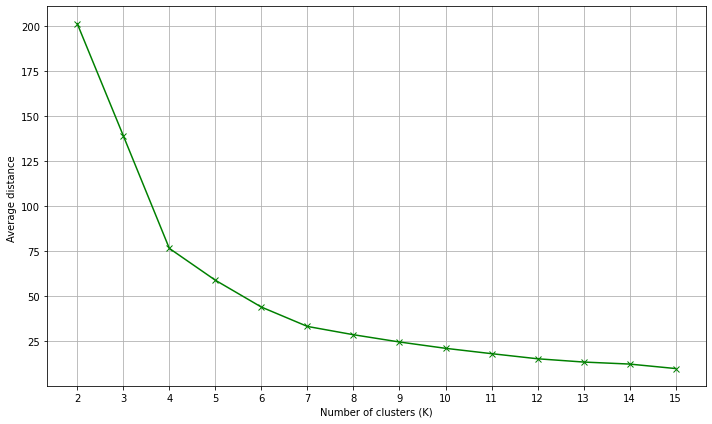

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# set number of clusters
kclusters = 4

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 0, 0, 2, 2, 2, 0], dtype=int32)

In [42]:
df_cluster_shops.insert(0, 'shop_cluster', kmeans.labels_)
df_cluster_shops = df_cluster_shops[['shop_id', 'shop_cluster']].set_index('shop_id')
df_cluster_shops.head()

,shop_cluster
shop_id,
2,2
3,2
4,2
5,2
6,0


In [43]:
shop_clusters = {}

def get_shop_cluster(shop_id):
    if shop_id not in shop_clusters:
        shop_clusters[shop_id] = df_cluster_shops.loc[shop_id]['shop_cluster']
    return shop_clusters[shop_id]

### Cluster analysis for cities

In [44]:
#df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
#df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items['city'] = df_sales_items['shop_id'].apply(lambda x: get_shop_city(x))
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month,city
0,0,2,1146.00000,1,Адыгея
1,0,3,767.00000,1,Балашиха
2,0,4,2114.00000,1,Волжский
3,0,6,3686.00000,1,Воронеж
4,0,7,2495.00000,1,Воронеж


In [45]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','city'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,city,item_cnt_month
0,1,Адыгея,1007.66667
1,1,Балашиха,904.00000
2,1,Волжский,1577.33333
3,1,Вологда,1521.50000
4,1,Воронеж,2489.85714
5,1,Жуковский,782.33333
6,1,Интернет,1592.33333
7,1,Казань,1316.00000
8,1,Калуга,2410.00000
9,1,Коломна,2196.33333


In [46]:
# for clustrer analysis
df_cluster_cities = df_cluster_sales.pivot_table(index=['city'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_cities.reset_index(inplace=True)
df_cluster_cities.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_cities.columns.values]
df_cluster_cities.head()

,city,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,Адыгея,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,Балашиха,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,Волжский,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,Вологда,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,Воронеж,2489.85714,2476.85714,2357.71429,1826.00000,1988.16667,2223.16667,2078.00000,2274.50000,2381.83333,2188.50000,2913.25000,4157.75000


In [47]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_cities = df_cluster_cities.drop('city', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_cities.values)
scaled_sales.shape

(31, 12)

In [48]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([155.69515854,  88.57575893,  52.8544258 ,  31.13420766,
        18.26961252,  13.15250172,  10.05189243,   7.95945857,
         6.32516435,   5.05445662,   4.07357843,   3.29410202,
         2.75133604,   2.40075899])

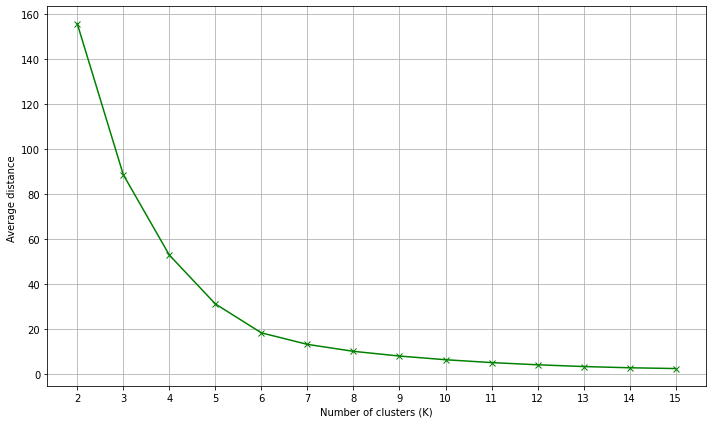

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# set number of clusters
kclusters = 6

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 1, 4, 5, 3, 4, 1, 4], dtype=int32)

In [51]:
df_cluster_cities.insert(0, 'city_cluster', kmeans.labels_)
df_cluster_cities = df_cluster_cities[['city', 'city_cluster']].set_index('city')
df_cluster_cities.head(10)

,city_cluster
city,
Адыгея,3
Балашиха,3
Волжский,1
Вологда,1
Воронеж,4
Выездная,5
Жуковский,3
Интернет,4
Казань,1


In [52]:
city_clusters = {}

def get_city_cluster(city):
    if city not in city_clusters:
        city_clusters[city] = df_cluster_cities.loc[city]['city_cluster']
    return city_clusters[city]

## Cluster analysis for categories

In [53]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id', 'category'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,category,item_cnt_day,month
0,0,2,Аксессуары - PS3,25.00000,1
1,0,2,Аксессуары - PS4,9.00000,1
2,0,2,Аксессуары - PSP,10.00000,1
3,0,2,Аксессуары - PSVita,10.00000,1
4,0,2,Аксессуары - XBOX 360,12.00000,1


In [54]:
# for clustrer analysis
df_cluster_sales = df_sales.groupby(['month','category'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,category,item_cnt_month
0,1,PC - Гарнитуры/Наушники,1.00000
1,1,Аксессуары - PS2,1.00000
2,1,Аксессуары - PS3,2.35665
3,1,Аксессуары - PS4,3.59714
4,1,Аксессуары - PSP,1.85938
5,1,Аксессуары - PSVita,1.69014
6,1,Аксессуары - XBOX 360,2.93394
7,1,Аксессуары - XBOX ONE,2.46718
8,1,Доставка товара,48.37500
9,1,Игровые консоли - PS3,2.19495


In [55]:
# for clustrer analysis
df_cluster_categories = df_cluster_sales.pivot_table(index=['category'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_categories.reset_index(inplace=True)
df_cluster_categories.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_categories.columns.values]
df_cluster_categories.head()

,category,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,PC - Гарнитуры/Наушники,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Аксессуары - PS2,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Аксессуары - PS3,2.35665,1.96922,1.78645,1.55399,1.51469,1.53602,1.53399,1.56831,1.54887,1.56675,1.73292,2.84758
3,Аксессуары - PS4,3.59714,3.85932,2.96505,2.56667,2.37792,2.50641,2.64142,2.71792,3.00764,2.80589,3.08746,5.35588
4,Аксессуары - PSP,1.85938,1.86111,1.85714,1.64167,1.52778,1.75000,1.84426,1.85263,1.64615,1.58904,1.87755,1.65000


In [56]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_categories = df_cluster_categories.drop('category', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_categories.values)
scaled_sales.shape

(84, 12)

In [57]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([174.38291586,  86.98851414,  44.79922857,  17.85800957,
         9.55633198,   6.4163758 ,   3.90717746,   3.07044052,
         2.52177099,   2.03229061,   1.6536    ,   1.30251554,
         0.98368277,   0.85005418])

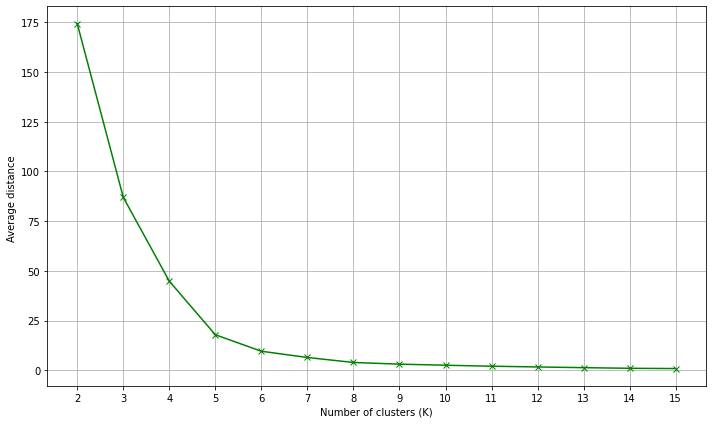

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# set number of clusters
kclusters = 5

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 3], dtype=int32)

In [60]:
df_cluster_categories.insert(0, 'category_cluster', kmeans.labels_)
df_cluster_categories = df_cluster_categories[['category', 'category_cluster']].set_index('category')
df_cluster_categories.head()

,category_cluster
category,
PC - Гарнитуры/Наушники,0
Аксессуары - PS2,0
Аксессуары - PS3,0
Аксессуары - PS4,0
Аксессуары - PSP,0


In [61]:
category_clusters = {}

def get_category_cluster(category):
    if category not in category_clusters:
        category_clusters[category] = df_cluster_categories.loc[category]['category_cluster']
    return category_clusters[category]

## Model

In [62]:
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()#.to_frame(name='item_cnt_month').reset_index()
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().to_frame(name='item_cnt_month').reset_index()
df_monthly_sales = df_sales.copy()
df_monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
5,0,2,481,1.00000,330.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
6,0,2,482,1.00000,3300.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
7,0,2,484,2.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
8,0,2,491,1.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
9,0,2,534,2.00000,798.00000,ТЦ,Программы - Обучающие,Адыгея,1


In [63]:
df_monthly_sales.loc[(df_monthly_sales['date_block_num']==0) & (df_monthly_sales['item_id'] == 2552) & (df_monthly_sales['shop_id'] == 25)]

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
19545,0,25,2552,0.00000,0.00000,ТРК,Музыка - Винил,Москва,1


In [64]:
# clip all cnt
#df_monthly_sales['item_cnt_day'] = np.clip(df_monthly_sales['item_cnt_day'], 0, 20)

In [65]:
df_monthly_sales.describe()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,month
count,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000
mean,14.66207,33.08813,10680.81598,2.26840,2113.40267,6.15391
std,9.54382,16.47024,6238.71724,8.65779,15321.22651,3.45497
min,0.00000,2.00000,0.00000,-22.00000,-33787.00000,1.00000
25%,6.00000,21.00000,5046.00000,1.00000,249.00000,3.00000
50%,14.00000,31.00000,10497.00000,1.00000,537.00000,6.00000
75%,23.00000,48.00000,16060.00000,2.00000,1490.00000,9.00000
max,33.00000,59.00000,22169.00000,2253.00000,6264230.00000,12.00000


In [66]:
df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt_day', fill_value=0)
#df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values=['item_cnt_day', 'revenue'], fill_value=0)
df.reset_index(inplace=True)
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [67]:
#df.columns = [ ''.join((name, str(date))) for (name, date) in df.columns.values]
#df['item_cnt_day34'] = np.nan
#df['revenue34'] = np.nan
df[34] = np.nan
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
count,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,0.00000
mean,31.96317,11458.02437,0.31437,0.30627,0.35182,0.25630,0.25577,0.29979,0.27967,0.29958,...,0.20132,0.19610,0.18609,0.17286,0.15330,0.15108,0.15800,0.17417,0.16990,NaN
std,16.70215,6133.50254,1.52184,1.61007,2.06599,1.36924,2.02436,3.34233,2.75611,2.93574,...,1.53860,1.50277,3.60501,2.86066,1.71125,1.58824,1.60870,4.95418,4.03456,NaN
min,2.00000,0.00000,-13.00000,-4.00000,-2.00000,-2.00000,-1.00000,-1.00000,-2.00000,-2.00000,...,-1.00000,-2.00000,-1.00000,-1.00000,-1.00000,-1.00000,-2.00000,-1.00000,-1.00000,NaN
25%,18.00000,6246.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
max,59.00000,22169.00000,169.00000,130.00000,259.00000,175.00000,504.00000,766.00000,799.00000,820.00000,...,300.00000,291.00000,1242.00000,742.00000,444.00000,482.00000,436.00000,1644.00000,2253.00000,NaN


In [68]:
#df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
#df_test = df_test.fillna(0)
#df_test.drop(['ID'], axis=1, inplace=True)
#df_test.head()

In [69]:
# calc prev month
df['prev0'] = np.nan
df['prev_diff0'] = np.nan
df['mean3_0'] = np.nan
df['mean6_0'] = np.nan
#df_test['prev_year0'] = np.nan
#df_test['revenue_prev0'] = np.nan
#df_test['revenue_prev_diff0'] = np.nan
#df_test['revenue_prev_year0'] = np.nan
for col in range(1, 35):
    df[''.join(('prev', str(col)))] = df[col-1]
    df[''.join(('prev_diff', str(col)))] = df[col] - df[col-1]
    df[''.join(('mean3_', str(col)))] = np.nan

    if col > 2:
        df[''.join(('mean3_', str(col)))] = (df[col-1] + df[col-2] + df[col-3])/3
        
    df[''.join(('mean6_', str(col)))] = np.nan
    if col > 5:
        df[''.join(('mean6_', str(col)))] = (df[col-1] + df[col-2] + df[col-3] + df[col-4] + df[col-5] + df[col-6])/6
        
#    df_test[''.join(('revenue_prev_year', str(col)))] = np.nan
#    df_test[''.join(('prev_year', str(col)))] = np.nan
#    if col > 11:
#        df_test[''.join(('prev_year', str(col)))] = df_test[col-12]
#        df_test[''.join(('revenue_prev_year', str(col)))] = df_test[''.join(('revenue', str(col-12)))]
#    df_test[''.join(('revenue_prev', str(col)))] = df_test[''.join(('revenue', str(col-1)))]
#    df_test[''.join(('revenue_prev_diff', str(col)))] = df_test[''.join(('revenue_prev', str(col)))] - df_test[''.join(('revenue_prev', str(col-1)))]
        
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,mean3_32,mean6_32,prev33,prev_diff33,mean3_33,mean6_33,prev34,prev_diff34,mean3_34,mean6_34
0,2,27,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,NaN,0.00000,0.00000
1,2,30,0,0,1,0,0,1,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,NaN,0.00000,0.00000
2,2,31,0,4,1,1,0,0,0,0,...,0.00000,0.00000,0,1,0.00000,0.00000,1,NaN,0.33333,0.16667
3,2,32,0,0,0,0,0,0,0,0,...,0.33333,0.33333,0,0,0.33333,0.16667,0,NaN,0.33333,0.16667
4,2,33,1,0,0,0,0,0,0,0,...,0.33333,0.50000,1,-1,0.66667,0.66667,0,NaN,0.33333,0.50000


In [70]:
# calc quarts
for col in range(2, 35):
    if (col+1)%3 == 0:
        q = (col+1)//3
        df[''.join(('Q', str(q)))] = df[col] + df[col-1] + df[col-2]
        #df_test[''.join(('revenueQ', str(q)))] = df_test[''.join(('revenue', str(col)))] + df_test[''.join(('revenue', str(col-1)))] + df_test[''.join(('revenue', str(col-2)))]
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,1,0,0,0,2,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,2,32,0,0,0,0,0,0,0,0,...,0,0,0,2,0,3,4,1,0,1
4,2,33,1,0,0,0,0,0,0,0,...,0,0,3,1,0,1,0,1,2,2


In [71]:
#df_test[[''.join(('itemQ', str(q))) for q in range(1,12)]].describe()
df[[''.join(('prev_diff', str(q))) for q in range(35)]].describe()

date_block_num,prev_diff0,prev_diff1,prev_diff2,prev_diff3,prev_diff4,prev_diff5,prev_diff6,prev_diff7,prev_diff8,prev_diff9,...,prev_diff25,prev_diff26,prev_diff27,prev_diff28,prev_diff29,prev_diff30,prev_diff31,prev_diff32,prev_diff33,prev_diff34
count,0.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,0.00000
mean,NaN,-0.00810,0.04555,-0.09553,-0.00053,0.04402,-0.02012,0.01991,0.01923,-0.01385,...,-0.06402,-0.00522,-0.01001,-0.01323,-0.01956,-0.00222,0.00691,0.01617,-0.00427,NaN
std,NaN,1.56898,2.02822,1.81659,1.98818,2.52818,1.64871,1.65958,2.96289,2.63597,...,3.33092,1.42996,3.55927,3.61362,2.10240,0.85882,0.95541,4.51431,5.78411,NaN
min,NaN,-146.00000,-86.00000,-205.00000,-110.00000,-129.00000,-462.00000,-267.00000,-278.00000,-353.00000,...,-1122.00000,-300.00000,-212.00000,-1240.00000,-540.00000,-108.00000,-128.00000,-102.00000,-1644.00000,NaN
25%,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
50%,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
75%,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
max,NaN,127.00000,259.00000,175.00000,497.00000,683.00000,255.00000,375.00000,548.00000,305.00000,...,126.00000,286.00000,1242.00000,550.00000,109.00000,62.00000,144.00000,1625.00000,2007.00000,NaN


In [72]:
df.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [73]:
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
count,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000
mean,31.96317,11458.02437,0.31437,0.30627,0.35182,0.25630,0.25577,0.29979,0.27967,0.29958,...,0.81186,0.89805,1.05420,0.81746,0.69765,0.70108,0.94213,0.66276,0.51225,0.48325
std,16.70215,6133.50254,1.52184,1.61007,2.06599,1.36924,2.02436,3.34233,2.75611,2.93574,...,5.45541,8.71877,10.76105,7.93057,6.82260,7.00860,10.40647,5.65313,6.71217,6.77494
min,2.00000,0.00000,-13.00000,-4.00000,-2.00000,-2.00000,-1.00000,-1.00000,-2.00000,-2.00000,...,-2.00000,-2.00000,-21.00000,-2.00000,-2.00000,-5.00000,-1.00000,-2.00000,-2.00000,-2.00000
25%,18.00000,6246.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,59.00000,22169.00000,169.00000,130.00000,259.00000,175.00000,504.00000,766.00000,799.00000,820.00000,...,1160.00000,2569.00000,3272.00000,2616.00000,1824.00000,1758.00000,2615.00000,1423.00000,1418.00000,1675.00000


In [74]:
#df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
#df_test = df_test.fillna(0)
#df_test.drop(['ID'], axis=1, inplace=True)
#df_test.head()

In [75]:
df_sells_in_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[i for i in range(35)], var_name='date_block_num', value_name='item_cnt_month')
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.00000
1,2,30,0,0.00000
2,2,31,0,0.00000
3,2,32,0,0.00000
4,2,33,0,1.00000


In [76]:
df_sells_in_prev_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('prev', str(i))) for i in range(35)], var_name='date_block_num', value_name='prev_month')
df_sells_in_prev_month.tail()

,shop_id,item_id,date_block_num,prev_month
14637905,59,22154,prev34,0.00000
14637906,59,22155,prev34,0.00000
14637907,59,22162,prev34,0.00000
14637908,59,22164,prev34,0.00000
14637909,59,22167,prev34,0.00000


In [77]:
df_sells_diff_in_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('prev_diff', str(i))) for i in range(35)], var_name='date_block_num', value_name='prev_diff')
df_sells_diff_in_month.tail()

,shop_id,item_id,date_block_num,prev_diff
14637905,59,22154,prev_diff34,NaN
14637906,59,22155,prev_diff34,NaN
14637907,59,22162,prev_diff34,NaN
14637908,59,22164,prev_diff34,NaN
14637909,59,22167,prev_diff34,NaN


In [78]:
df_sells_mean3 = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('mean3_', str(i))) for i in range(35)], var_name='date_block_num', value_name='mean3')
df_sells_mean3.tail()

,shop_id,item_id,date_block_num,mean3
14637905,59,22154,mean3_34,0.00000
14637906,59,22155,mean3_34,0.00000
14637907,59,22162,mean3_34,0.33333
14637908,59,22164,mean3_34,0.00000
14637909,59,22167,mean3_34,0.00000


In [79]:
df_sells_mean6 = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('mean6_', str(i))) for i in range(35)], var_name='date_block_num', value_name='mean6')
df_sells_mean6.tail()

,shop_id,item_id,date_block_num,mean6
14637905,59,22154,mean6_34,0.00000
14637906,59,22155,mean6_34,0.00000
14637907,59,22162,mean6_34,0.33333
14637908,59,22164,mean6_34,0.16667
14637909,59,22167,mean6_34,0.00000


In [80]:
#df_sells_prev_year = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('item_cnt_day_prev_year', str(i))) for i in range(35)], var_name='date_block_num', value_name='item_cnt_prev_year')
#df_sells_prev_year.tail()

In [81]:
#df_revenue_in_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue')
#df_revenue_in_month.tail()

In [82]:
#df_revenue_in_prev_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev')
#df_revenue_in_prev_month.tail()

In [83]:
#df_revenue_diff_in_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev_diff', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev_diff')
#df_revenue_diff_in_month.tail()

In [84]:
#df_revenue_prev_year = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev_year', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev_year')
#df_revenue_prev_year.tail()

In [85]:
df_sells_in_month['prev_month'] = df_sells_in_prev_month['prev_month']
df_sells_in_month['prev_diff'] = df_sells_diff_in_month['prev_diff']
df_sells_in_month['mean3'] = df_sells_mean3['mean3']
df_sells_in_month['mean6'] = df_sells_mean6['mean6']
#df_sells_in_month['item_cnt_prev_year'] = df_sells_prev_year['item_cnt_prev_year']
#df_sells_in_month['revenue'] = df_revenue_in_month['revenue']
#df_sells_in_month['revenue_prev'] = df_revenue_in_prev_month['revenue_prev']
#df_sells_in_month['revenue_prev_diff'] = df_revenue_diff_in_month['revenue_prev_diff']
#df_sells_in_month['revenue_prev_year'] = df_revenue_prev_year['revenue_prev_year']
#df_sells_in_month['date_block_num'] = df_sells_in_month['date_block_num'].apply(lambda x: int(x.replace('item_cnt_day','')))
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6
0,2,27,0,1.00000,NaN,NaN,NaN,NaN
1,2,30,0,0.00000,NaN,NaN,NaN,NaN
2,2,31,0,0.00000,NaN,NaN,NaN,NaN
3,2,32,0,0.00000,NaN,NaN,NaN,NaN
4,2,33,0,1.00000,NaN,NaN,NaN,NaN


In [86]:
df_sells_in_month['prev_itemQ'] = np.nan
#df_sells_in_month['prev_revenueQ'] = np.nan
# calc quarts
for month in range(3, 35):
    q = (month)//3
#    print(''.join(('Q', str(q))))
    df_sells_in_month.loc[df_sells_in_month['date_block_num'] == month, 'prev_itemQ'] = df[''.join(('Q', str(q)))].values
#    df_sells_in_month.loc[df_sells_in_month['date_block_num'] == month, 'prev_revenueQ'] = df_test[''.join(('revenueQ', str(q)))].values
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ
0,2,27,0,1.00000,NaN,NaN,NaN,NaN,NaN
1,2,30,0,0.00000,NaN,NaN,NaN,NaN,NaN
2,2,31,0,0.00000,NaN,NaN,NaN,NaN,NaN
3,2,32,0,0.00000,NaN,NaN,NaN,NaN,NaN
4,2,33,0,1.00000,NaN,NaN,NaN,NaN,NaN


In [87]:
# 45,18454
#df_sells_in_month.tail()
df_sells_in_month.loc[(df_sells_in_month['shop_id'] == 45) & (df_sells_in_month['item_id'] == 18454)]
#df_test.loc[(df_test['shop_id'] == 45) & (df_test['item_id'] == 18454)]
#len(df_test['Q1'].values)
#len(df_sells_in_month[df_sells_in_month['date_block_num'] == month,['prev_q']].values)

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ
302177,45,18454,0,0.00000,NaN,NaN,NaN,NaN,NaN
720403,45,18454,1,0.00000,0.00000,0.00000,NaN,NaN,NaN
1138629,45,18454,2,0.00000,0.00000,0.00000,NaN,NaN,NaN
1556855,45,18454,3,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
1975081,45,18454,4,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
2393307,45,18454,5,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
2811533,45,18454,6,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3229759,45,18454,7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3647985,45,18454,8,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4066211,45,18454,9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [88]:
%%time
df_sells_in_month['shop_type'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 8.19 s, sys: 171 ms, total: 8.36 s
Wall time: 8.4 s


In [89]:
%%time
df_sells_in_month['shop_mega'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_megality(x))

CPU times: user 14.9 s, sys: 1.46 s, total: 16.4 s
Wall time: 17.2 s


In [90]:
%%time
df_sells_in_month['shop_cluster'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_cluster(x))

CPU times: user 14.9 s, sys: 574 ms, total: 15.5 s
Wall time: 16 s


In [91]:
%%time
df_sells_in_month['subcategory'] = df_sells_in_month['item_id'].apply(lambda x: get_category(x))

CPU times: user 19.2 s, sys: 749 ms, total: 20 s
Wall time: 20.7 s


In [92]:
%%time
df_sells_in_month['digital'] = df_sells_in_month['item_id'].apply(lambda x: get_category_digitality(x))

CPU times: user 26 s, sys: 1.03 s, total: 27.1 s
Wall time: 28.5 s


In [93]:
%%time
df_sells_in_month['city'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 8.19 s, sys: 175 ms, total: 8.37 s
Wall time: 8.41 s


In [94]:
%%time
df_sells_in_month['city_cluster'] = df_sells_in_month['city'].apply(lambda x: get_city_cluster(x))

CPU times: user 15 s, sys: 341 ms, total: 15.3 s
Wall time: 15.4 s


In [95]:
%%time
df_sells_in_month['category_cluster'] = df_sells_in_month['subcategory'].apply(lambda x: get_category_cluster(x))

CPU times: user 14.6 s, sys: 312 ms, total: 14.9 s
Wall time: 15 s


In [96]:
df_sells_in_month['category'] = df_sells_in_month['subcategory'].str.split('[-(]', n=0).str[0].str.strip()

In [1]:
%%time
df_sells_in_month['month'] = df_sells_in_month['date_block_num']%12 + 1

NameError: name 'df_sells_in_month' is not defined

In [ ]:
df_sells_in_month[item_labels.columns.values] = df_sells_in_month['item_id'].apply(lambda x: get_items_features(x))

In [ ]:
# clip all
#df_sells_in_month['item_cnt_prev_month'] = np.clip(df_sells_in_month['item_cnt_prev_month'], 0, 20)
#df_sells_in_month['item_cnt_month'] = np.clip(df_sells_in_month['item_cnt_month'], 0, 20)
df_sells_in_month['prev_itemQ'].describe()

In [ ]:
df_sells_in_month.tail()

In [ ]:
df_sells_in_month.columns.values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

date_ix = 0

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values # convert to NumPy array

class CycleTransformator( BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self,  cycle_columns ):
        self._cycle_columns = cycle_columns
        self._cycle_stats = {}
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        for column in self._cycle_columns:
            self._cycle_stats[column] = { 'max': X[column].max(), 'min': X[column].min() }
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        self._df = pd.DataFrame(index=X.index)
        for column in self._cycle_columns:
            self._df[column+'_sin'] = np.sin(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))
            self._df[column+'_cos'] = np.cos(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))

        #self._df = self._df.reset_index(drop=True)
        #print('Cycle transform shape is {}'.format(self._df.values.shape))
        return self._df.values

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [95]:
#num_attribs = ['item_cnt_prev_month','item_cnt_prev_diff','prev_itemQ','item_cnt_prev_year']
num_attribs = ['prev_month','prev_diff', 'prev_itemQ', 'mean3', 'mean6']
l12_cols = item_labels.columns.values
num_attribs = np.concatenate([num_attribs,l12_cols])
#num_attribs = ['digital']
#cat_attribs = ['shop_cluster', 'category_cluster']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster']
cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'category', 'city']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'category']
#cat_attribs = ['shop_cluster', 'category']
#num_attribs = ['item_id','shop_id','digital']
#cat_attribs = ['category']
date_attribs = ['month']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])
counted_pipeline = Pipeline([
    ('cycle_transformator', CycleTransformator(cycle_columns=date_attribs)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
#    ('cat_pipeline', cat_pipeline),
    ('counted_pipeline', counted_pipeline),
])

In [106]:
from sklearn.model_selection import TimeSeriesSplit

df_sells_in_month = df_sells_in_month.dropna()

#X_train_data = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()
#X_test_data = df_sells_in_month[df_sells_in_month['date_block_num'] > 23].copy()
#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'item_cnt_prev_diff','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]

#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]

X_train = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()
X_test = df_sells_in_month[(df_sells_in_month['date_block_num'] > 23) & (df_sells_in_month['date_block_num'] < 34)].copy()
X_pred = df_sells_in_month[df_sells_in_month['date_block_num'] == 34].copy()


Y_train = X_train['item_cnt_month'].copy()
Y_test = X_test['item_cnt_month'].copy()

tscv = TimeSeriesSplit(n_splits=5)

In [107]:
X_train['date_block_num'].unique()

array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype=object)

In [108]:
Y_train.describe()

count   3855600.00000
mean          0.18929
std           1.10297
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max          20.00000
Name: item_cnt_month, dtype: float64

In [109]:
Y_test.describe()

count   2142000.00000
mean          0.23893
std           1.06524
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max          20.00000
Name: item_cnt_month, dtype: float64

In [110]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
X_pred_prepared = full_pipeline.transform(X_pred)
X_train_prepared.shape

(3855600, 7)

In [101]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(degree=2)
#X_train_prepared = poly.fit_transform(X_train_prepared)
#X_test_prepared = poly.transform(X_test_prepared)
#X_train_prepared.shape

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Deviation:", scores.std())

In [111]:
%%time

from sklearn.tree import DecisionTreeRegressor

# train
tree_reg = DecisionTreeRegressor(random_state=57)
tree_reg.fit(X_train_prepared, Y_train)

# predict
predictions = tree_reg.predict(X_train_prepared)

#scores = cross_val_score(tree_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Tree: ', scores.mean(), scores.std()))
#tree_rmse_scores = np.sqrt(-scores)
#display_scores(tree_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = tree_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_pred , Y_test)

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.000001
Wall time: 1.87 s


In [112]:
%%time
from sklearn.linear_model import LinearRegression

# train
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, Y_train)
# predict
predictions = lin_reg.predict(X_train_prepared)

scores = cross_val_score(lin_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
print('%s: %f (%f)' % ('LinReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lin_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_test, Y_pred)

LinReg: : 1.000000 (0.000000)
R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.000000
Wall time: 2.28 s


In [113]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=57, n_jobs=4, verbose=1)
print('Fitting...')
forest_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = forest_reg.predict(X_train_prepared)

print('Cross validating...')
scores = cross_val_score(forest_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
print('%s: %f (%f)' % ('Forest: ', scores.mean(), scores.std()))
#forest_rmse_scores = np.sqrt(-scores)
#display_scores(forest_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = forest_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   47.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Predicting...


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Cross validating...


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.1min finished


Forest: : 0.999953 (0.000062)
R2-score: 1.00
Testing...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


R2-score: 1.00
MSE: 0.000002
Wall time: 2min 58s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


In [114]:
feature_importances = forest_reg.feature_importances_

In [115]:
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])
counted_encoder = counted_pipeline.named_steps["cycle_transformator"]
counted_attribs = list(counted_encoder._df.columns)
#attributes = num_attribs + cat_one_hot_attribs + counted_attribs
attributes = num_attribs + counted_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.6379830148152325, 'prev_diff'),
 (0.36201247778008416, 'prev_month'),
 (1.1965666128614614e-06, 'mean6'),
 (1.1398270549003047e-06, 'mean3'),
 (8.699787535824571e-07, 'prev_itemQ'),
 (7.762810179514046e-07, 'month_sin'),
 (5.247512440489779e-07, 'month_cos')]

In [116]:
%%time
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

lasso.fit(X_train_prepared, Y_train)
# predict
predictions = lasso.predict(X_train_prepared)

scores = cross_val_score(lasso, X_train_prepared, Y_train, cv=tscv, scoring="r2")
print('%s: %f (%f)' % ('Lasso: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lasso.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Lasso: : 0.947181 (0.020974)
R2-score: 0.97
Testing...
R2-score: 0.97
MSE: 0.036418
Wall time: 3.24 s


In [117]:
%%time
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.8)
enet.fit(X_train_prepared, Y_train)
# predict
predictions = enet.predict(X_train_prepared)

scores = cross_val_score(enet, X_train_prepared, Y_train, cv=tscv, scoring="r2")
print('%s: %f (%f)' % ('Enet: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = enet.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Enet: : 0.951163 (0.018239)
R2-score: 0.97
Testing...
R2-score: 0.97
MSE: 0.034744
Wall time: 3.08 s


In [120]:
%%time
from sklearn import svm

# train
svm_reg = svm.SVR(gamma='auto', verbose=True, tol=0.001, max_iter=1000)
print('Fitting...')
svm_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = svm_reg.predict(X_train_prepared)

#print('Crossing...')
#scores = cross_val_score(svm_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('SVM: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = svm_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...
[LibSVM]

C:\Users\magav\Anaconda3\envs\ds\lib\site-packages\sklearn\svm\_base.py:228: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Predicting...
R2-score: -28.35
Testing...
R2-score: -30.22
MSE: 35.426975
Wall time: 7min 3s


In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor

# train
neighbor_reg = KNeighborsRegressor(n_jobs=4)
print('Fitting...')
neighbor_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = neighbor_reg.predict(X_train_prepared)

#print('Cross validating...')
#scores = cross_val_score(neighbor_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('NeighborReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = neighbor_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...


In [ ]:
#df_test['34_scaled'] = (20*(df_test[34] - np.min(df_test[34]))/np.ptp(df_test[34]))   
#df_test['34'] = np.clip(df_test[34], 0, 20)

In [118]:
#X_prepared = full_pipeline.transform(X_pred)
Y_pred = enet.predict(X_pred_prepared)
#Y_pred = forest_reg.predict(X_pred_prepared)

In [119]:
df_submission = pd.read_csv('sample_submission.csv')
#df_submission['item_cnt_month'] = df_test['34_scaled']
#df_submission['item_cnt_month'] = np.clip(df_prediction['item_cnt_month'], 0, 20)
df_submission['item_cnt_month'] = np.clip(Y_pred, 0, 20)
df_submission.to_csv('submission103_9.csv', index=False)
df_submission.head()

,ID,item_cnt_month
0,0,0.24702
1,1,0.02150
2,2,0.17572
3,3,0.06660
4,4,0.02150


In [ ]:
np.min(Y_pred)

submission103_1.csv
6 minutes ago by Andrey Vest

Lasso, merge test, unpivot, previous and mean values, cluster features
1.20394

submission103_2.csv
6 minutes ago by Andrey Vest

Lasso, merge test, unpivot, previous and mean values, cluster features
1.22310

submission103_6.csv
just now by Andrey Vest

Elastic, merge test, unpivot, previous and mean values , without cluster features
1.23524

submission103_8.csv
a few seconds ago by Andrey Vest

Elastic, merge test, unpivot, previous and mean values , without cluster features, clipped all
1.20528